# eP-ALM: Efficient Perceptual Augmentation of Language Models

This notebook contains some scripts to run the inference with eP-ALM on VQA and Captioning. You can similarly implement the inference on video and audio modalities.


# Import

In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import re

import torch
from torch import nn
from torchvision import transforms


from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from accelerate import Accelerator
from models.opt import OPTModel, OPTConfig, OPTForCausalLM
import models.vit 

from PIL import Image
import json 
import os

from torchvision import transforms

import argparse 
from transformers.tokenization_utils_base import BatchEncoding
from models.epalm import ePALM

import os
import numpy as np

from transformers import AutoTokenizer

import ruamel_yaml as yaml

## Utils

In [3]:
image_size = 224
normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

transform = transforms.Compose([
            transforms.Resize((image_size,image_size),interpolation=Image.BICUBIC),
            transforms.ToTensor(),
            normalize,
            ])  

/tmp/ipykernel_1746605/3827487731.py:5: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.Resize((image_size,image_size),interpolation=Image.BICUBIC),
/data/mshukor/envs/opt/lib/python3.8/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


# Captioning

### Model

In [ ]:
os.environ['TORCH_HOME'] = '/home/mshukor/.cache/torch'


# config = '/home/mshukor/ep-alm/configs/image/ePALM_pt_L_caption.yaml'
# config = yaml.load(open(config, 'r'), Loader=yaml.Loader)

config = '/home/mshukor/ep-alm/configs/image/ePALM_caption.yaml'
config = yaml.load(open(config, 'r'), Loader=yaml.Loader)


text_model = 'facebook/opt-2.7b' 
vision_model_name = 'vit_base_patch16_224'

# text_model = 'facebook/opt-6.7b' 
# vision_model_name = 'vit_large_patch16_224'


start_layer_idx = 19
end_layer_idx = 31
low_cpu = True 
model = ePALM(opt_model_name=text_model, 
               vision_model_name=vision_model_name, 
               use_vis_prefix=True, 
               start_layer_idx=start_layer_idx, 
               end_layer_idx=end_layer_idx, 
               return_hidden_state_vision=True, 
               config=config,
               low_cpu=low_cpu
)
print("done")

In [ ]:
device = torch.device("cuda")
model.to(device)
print(device)

In [96]:
checkpoint_path = '/data/mshukor/logs/eplam/models/float32/ePALM_caption/checkpoint_best.pth'
# checkpoint_path = '/data/mshukor/logs/eplam/models/accelerate/ePALM_pt_L_acc_caption/checkpoint_best.pth'
checkpoint = torch.load(checkpoint_path, map_location='cpu') 
state_dict = checkpoint['model']
msg = model.load_state_dict(state_dict,strict=False)  

### Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(text_model, use_fast=False)
eos_token = tokenizer.eos_token
pad_token = tokenizer.pad_token

### Eval

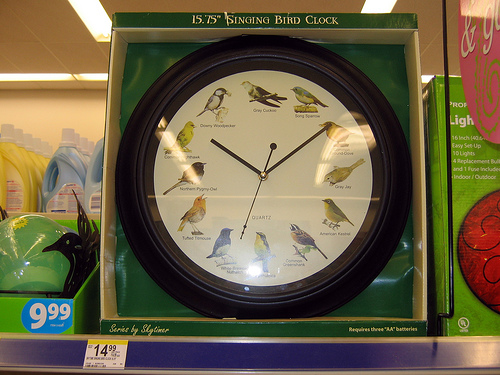

In [100]:
image_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000386193.jpg'
img = Image.open(image_path).convert('RGB') 
image = transform(img)
image = image.to(device,non_blocking=True).unsqueeze(0)
img

In [108]:
do_sample=False
num_beams=3
max_length=30

In [110]:
text = ['']  
text_input = tokenizer(text, padding='longest', return_tensors="pt").to(device) 

with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):

    out = model(image=image, text=text_input, mode='generate', return_dict=True, max_length=max_length, 
                do_sample=do_sample, num_beams=num_beams)

out_decode = []
for i, o in enumerate(out):
    res = tokenizer.decode(o)
    response = res.split('</s>')[1].replace(pad_token, '').replace('</s>', '').replace(eos_token, '') # skip_special_tokens=True

print(response)

A clock is displayed on a shelf in a store.


## VQA

### Model

In [111]:
os.environ['TORCH_HOME'] = '/home/mshukor/.cache/torch'



config = '/home/mshukor/ep-alm/configs/image/ePALM_vqa.yaml'
config = yaml.load(open(config, 'r'), Loader=yaml.Loader)


text_model = 'facebook/opt-2.7b' 
vision_model_name = 'vit_base_patch16_224'

# text_model = 'facebook/opt-6.7b' 
# vision_model_name = 'vit_large_patch16_224'


start_layer_idx = 19
end_layer_idx = 31
low_cpu = True 
model = ePALM(opt_model_name=text_model, 
               vision_model_name=vision_model_name, 
               use_vis_prefix=True, 
               start_layer_idx=start_layer_idx, 
               end_layer_idx=end_layer_idx, 
               return_hidden_state_vision=True, 
               config=config,
               low_cpu=low_cpu
)
print("done")

Loading ePALM ...
Loading:  facebook/opt-2.7b
OPTConfig {
  "_name_or_path": "facebook/opt-2.7b",
  "_remove_final_layer_norm": false,
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "OPTForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 2,
  "do_layer_norm_before": true,
  "dropout": 0.1,
  "end_layer_idx": 31,
  "eos_token_id": 2,
  "ffn_dim": 10240,
  "hidden_size": 2560,
  "init_std": 0.02,
  "layerdrop": 0.0,
  "max_position_embeddings": 2048,
  "model_type": "opt",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "pad_token_id": 1,
  "prefix": "</s>",
  "select_higher_step": false,
  "start_layer_idx": 19,
  "text_step": 1,
  "torch_dtype": "float16",
  "transformers_version": "4.24.0",
  "use_cache": false,
  "use_vis_prefix": true,
  "vocab_size": 50272,
  "word_embed_proj_dim": 2560
}

Loading:  vit_base_patch16_224
Build connector: linear
done


In [117]:
checkpoint_path = '/data/mshukor/logs/eplam/models/float32/ePALM_vqa/checkpoint_best.pth'
checkpoint = torch.load(checkpoint_path, map_location='cpu') 
state_dict = checkpoint['model']
msg = model.load_state_dict(state_dict,strict=False)  

In [135]:
device = torch.device("cuda")
model.to(device)
print(device)

cuda


### Tokenizer

In [116]:
tokenizer = AutoTokenizer.from_pretrained(text_model, use_fast=False)
eos_token = tokenizer.eos_token
pad_token = tokenizer.pad_token


special_answer_token = '</a>'

if special_answer_token is not None:
    special_tokens_dict = {'additional_special_tokens': [special_answer_token]}
    tokenizer.add_special_tokens(special_tokens_dict)

In [147]:
do_sample=False
num_beams=3
max_length=30

### Eval

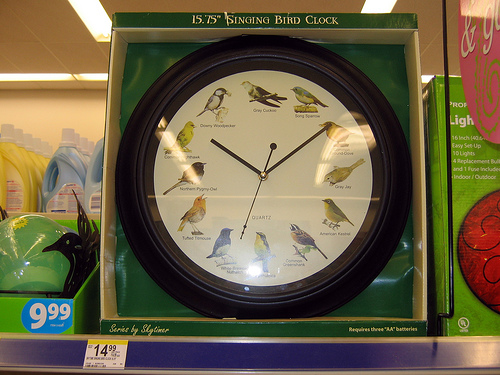

In [123]:
image_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000386193.jpg'
img = Image.open(image_path).convert('RGB') 
image = transform(img)
image = image.to(device,non_blocking=True).unsqueeze(0)
img

In [151]:
# question = ['What is this object?']
question = ['What is this object?', 'What is the color of the object next to the clock?']

if special_answer_token is not None:
    question = [q+'?'+special_answer_token for q in question]
else:
    question = [q+eos_token for q in question]

question_input = tokenizer(question, padding='longest', return_tensors="pt").to(device) 

with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):

    out = model(image=image, text=question_input, mode='generate', return_dict=True, max_length=max_length, 
                do_sample=do_sample, num_beams=num_beams)            


responses = []
for o in out:
    o_list = o.tolist()
    if special_answer_token is not None:
        response = tokenizer.decode(o_list).split(special_answer_token)[1].replace(pad_token, '').replace('</s>', '').replace(eos_token, '') # skip_special_tokens=True
    else:
        response = tokenizer.decode(o_list).split('</s>')[2].replace(pad_token, '').replace('</s>', '').replace(eos_token, '') # skip_special_tokens=True
    responses.append(response)
print(responses)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


[' clock', ' green']
